In [1]:
import pandas as pd    
import geopandas as gpd
import datetime
from geopandas.tools import geocode
from shapely.geometry import Point
import numpy as np
import shapely
from shapely import speedups
speedups.enabled
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

### Importing Zip Codes

In [2]:
# Loads zip code boundary data
zipcodes_url = 'https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson'
z = gpd.read_file(zipcodes_url)

In [3]:
# Creates a dataframe "zips" of zip codes, areas, and geometries
zip_cols = ['ZIPCODE', 'SHAPE_Area', 'geometry']
zips = z.loc[:,zip_cols]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)

new_cols = ['Zipcode', 'Area (ft^2)?']
rename_dict = {}
for i in range(len(zip_cols)-1):
    rename_dict[zip_cols[i]] = new_cols[i]
zips.rename(columns=rename_dict, inplace=True)
zips.sort_values(by='Zipcode', inplace=True)
zips.set_index(np.arange(0,len(zips),1), inplace=True)
zips.index.name = 'ID'

In [4]:
zips.head() #Check the output of zips file

,Zipcode,Area (ft^2)?,geometry
ID,,,
0,98001,5.324255e+08,"POLYGON ((-122.22992 47.35377, -122.22992 47.3..."
1,98002,2.055688e+08,"POLYGON ((-122.22921 47.35375, -122.22921 47.3..."
2,98003,3.170769e+08,"POLYGON ((-122.30960 47.35795, -122.31323 47.3..."
3,98004,2.014501e+08,"MULTIPOLYGON (((-122.21458 47.65298, -122.2147..."
4,98005,2.113641e+08,"POLYGON ((-122.15876 47.66065, -122.16408 47.6..."


<AxesSubplot:>

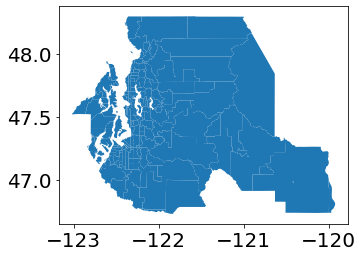

In [5]:
zips.plot()

- Now we need to join the zips geodataframe to the census tracts using the sjoin function in geopandas

In [6]:
# Loads census tract boundary data
census_url = 'https://opendata.arcgis.com/datasets/de58dc3e1efc49b782ab357e044ea20c_9.geojson'
t = gpd.read_file(census_url)

In [7]:
# Creates a dataframe "tracts" of tract number, areas, and geometries
tract_cols = ['NAME10', 'SHAPE_Area', 'geometry']
tracts = t.loc[:,tract_cols]
tracts['NAME10'] = tracts['NAME10'].astype(float)
new_cols = ['Tract', 'Area (ft^2)?', 'geometry']
rename_dict = {}
for i in range(len(tract_cols)):
    rename_dict[tract_cols[i]] = new_cols[i]
tracts.rename(columns=rename_dict, inplace=True)
tracts.sort_values(by='Tract', inplace=True)
tracts.set_index(np.arange(0,len(tracts),1), inplace=True)
tracts.index.name = 'ID'

In [8]:
len(tracts) #Check output against the number of census tracts, should be 135 if we picked the correct function works

135

- Now Filter out the census tracts which are outliers when we normalize by area 

In [9]:
# Filters out tracts with irregular traffic data
filter1 = tracts.Tract == 260.01
filter2 = tracts.Tract == 264.0
indices1 = tracts[filter1].index
indices2 = tracts[filter2].index
tracts.drop(indices1, inplace=True)
tracts.drop(indices2, inplace=True)

In [10]:
len(tracts) #Double check the two subtracted tracts

133

- Now we want to join our two metric census tracts and zipcodes.  

In [11]:
# Joins zip codes with census tracts
ziptracts = gpd.sjoin(zips, tracts, op='overlaps')
zip_cols = ['Zipcode', 'Tract', 'Area (ft^2)?_left', 'geometry']
ziptracts = ziptracts[zip_cols]
ziptracts.rename(columns={'Area (ft^2)?_left': 'Area (ft^2)?'}, inplace=True)

In [12]:
# Defines x and y boundaries of area covered by tracts
minx = min(tracts.geometry.bounds.minx)
maxx = max(tracts.geometry.bounds.maxx)
miny = min(tracts.geometry.bounds.miny)
maxy = max(tracts.geometry.bounds.maxy)

# Shrinks the area covered by ziptracts to the area covered by tracts
minx_filter = minx < ziptracts.geometry.bounds.minx
maxx_filter = maxx > ziptracts.geometry.bounds.maxx
miny_filter = miny < ziptracts.geometry.bounds.miny
maxy_filter = maxy > ziptracts.geometry.bounds.maxy

ziptracts = ziptracts[minx_filter & maxx_filter & miny_filter & maxy_filter]

<AxesSubplot:>

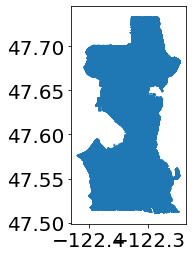

In [13]:
ziptracts.plot()

In [14]:
ziptracts['Zipcode'].unique

<bound method Series.unique of ID
58    98101
59    98102
75    98122
58    98101
59    98102
      ...  
77    98126
80    98136
79    98134
81    98144
80    98136
Name: Zipcode, Length: 233, dtype: int64>

In [15]:
ziptracts.head()

,Zipcode,Tract,Area (ft^2)?,geometry
ID,,,,
58,98101,74.02,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6..."
59,98102,74.02,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6..."
75,98122,74.02,6.454818e+07,"POLYGON ((-122.32272 47.61931, -122.32282 47.6..."
58,98101,74.01,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6..."
59,98102,74.01,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6..."


- Need to load bike lane and walkway data

In [16]:
#Bike lanes and walkways
df_SND = gpd.read_file('Street_Network_Database_SND.geojson')

In [17]:
df_SND.columns

Index(['OBJECTID', 'F_INTR_ID', 'T_INTR_ID', 'SND_ID', 'SND_FEACOD',
       'CITYCODE', 'STNAME_ID', 'ST_CODE', 'ARTERIAL_C', 'SEGMENT_TY',
       'AGENCY_COD', 'ACCESS_COD', 'DIVIDED_CO', 'STRUCTURE_', 'LEGALLOC_C',
       'VEHICLE_US', 'GIS_SEG_LE', 'L_ADRS_FRO', 'L_ADRS_TO', 'R_ADRS_FRO',
       'R_ADRS_TO', 'ORD_PRE_DI', 'ORD_STREET', 'ORD_STRE_1', 'ORD_SUF_DI',
       'ORD_STNAME', 'L_CITY', 'L_STATE', 'L_ZIP', 'R_CITY', 'R_STATE',
       'R_ZIP', 'SNDSEG_UPD', 'COMPKEY', 'COMPTYPE', 'UNITID', 'UNITID2',
       'SHAPE_Leng', 'geometry'],
      dtype='object')

In [18]:
df_SND.head()

,OBJECTID,F_INTR_ID,T_INTR_ID,SND_ID,SND_FEACOD,CITYCODE,STNAME_ID,ST_CODE,ARTERIAL_C,SEGMENT_TY,...,R_CITY,R_STATE,R_ZIP,SNDSEG_UPD,COMPKEY,COMPTYPE,UNITID,UNITID2,SHAPE_Leng,geometry
0,1,17740,17791,33478,5,1,566,0,1,1,...,SEATTLE,WA,98108,2007-04-22,8460,68,04805,0820,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47..."
1,2,11391,11295,20097,1,1,659,0,0,1,...,SEATTLE,WA,98102,2007-04-22,9236,68,05465,0010,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47..."
2,3,982,979,42208,1,0,1797,40,0,1,...,LAKE FOREST PARK,WA,98155,2004-05-19,0,0,0,0,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47..."
3,4,11695,11696,20460,77,1,1444,20,0,6,...,SEATTLE,WA,98122,2004-05-19,0,0,0,0,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47..."
4,5,6257,6252,9237,1,1,2086,0,0,1,...,SEATTLE,WA,98107,2012-10-12,18575,68,14630,0200,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47..."


In [19]:
lane_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
bike_lane = df_SND[lane_columns]

In [20]:
bike_lane.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry
0,1,2007-04-22,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47..."
1,1,2007-04-22,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47..."
2,1,2004-05-19,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47..."
3,6,2004-05-19,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47..."
4,1,2012-10-12,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47..."


In [21]:
bike_lane['Year'] = pd.DatetimeIndex(bike_lane['SNDSEG_UPD']).year


/home/shaung/anaconda3/envs/vis-pr/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [22]:
bike_lane.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry,Year
0,1,2007-04-22,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47...",2007
1,1,2007-04-22,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47...",2007
2,1,2004-05-19,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47...",2004
3,6,2004-05-19,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47...",2004
4,1,2012-10-12,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47...",2012


In [23]:
bike_lane.drop(columns='SNDSEG_UPD')

,SEGMENT_TY,SHAPE_Leng,geometry,Year
0,1,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47...",2007
1,1,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47...",2007
2,1,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47...",2004
3,6,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47...",2004
4,1,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47...",2012
...,...,...,...,...
34201,1,305.488287,"LINESTRING (-122.31417 47.67145, -122.31410 47...",2021
34202,1,97.898257,"LINESTRING (-122.34210 47.60772, -122.34250 47...",2021
34203,1,421.473404,"LINESTRING (-122.32610 47.46873, -122.32440 47...",2021
34204,1,238.008808,"LINESTRING (-122.32440 47.46874, -122.32344 47...",2021


In [24]:
# # Joins zip codes with bike racks
z_bl = gpd.sjoin(ziptracts, bike_lane, op='contains')

In [25]:
z_bl.head()

,Zipcode,Tract,Area (ft^2)?,geometry,index_right,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,Year
ID,,,,,,,,,
58,98101,74.02,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",13878,1,2007-04-22,306.091173,2007
58,98101,74.01,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",13878,1,2007-04-22,306.091173,2007
58,98101,84.00,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",13878,1,2007-04-22,306.091173,2007
58,98101,81.00,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",13878,1,2007-04-22,306.091173,2007
58,98101,82.00,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",13878,1,2007-04-22,306.091173,2007


In [31]:
z_bl= z_bl[z_bl['SEGMENT_TY']==6]

In [34]:
len(z_bl)

3105

In [37]:
z_bl.dissolve(by=['Zipcode','Year'], aggfunc = 'sum')

geometry    Tract  \
Zipcode Year                                                               
98101   2004  POLYGON ((-122.34598 47.60892, -122.34490 47.6...  3515.25   
        2005  POLYGON ((-122.34598 47.60892, -122.34490 47.6...   703.05   
        2011  POLYGON ((-122.34598 47.60892, -122.34490 47.6...   703.05   
        2018  POLYGON ((-122.34598 47.60892, -122.34490 47.6...   703.05   
98102   2004  POLYGON ((-122.33574 47.64203, -122.33108 47.6...  3300.18   
...                                                         ...      ...   
98144   2014  POLYGON ((-122.31857 47.59741, -122.31857 47.5...  1192.03   
        2015  POLYGON ((-122.31857 47.59741, -122.31857 47.5...  3576.09   
        2017  POLYGON ((-122.31857 47.59741, -122.31857 47.5...  1192.03   
98195   2015  POLYGON ((-122.31218 47.65338, -122.31215 47.6...   337.06   
        2019  POLYGON ((-122.31218 47.65338, -122.31215 47.6...   337.06   

              Area (ft^2)?  index_right  SEGMENT_TY   SHAPE_Leng  
Zipcode Year                                                      
98101   2004  6.615055e+08       344970         270  9413.438596  
        2005  1.323011e+08        93024          54  1096.391972  
        2011  1.323011e+08       175680          54   333.201417  
        2018  1.323011e+08       297486          54  3133.635847  
98102   2004  2.074651e+09       349416         288  8342.494684  
...                    ...          ...         ...          ...  
98144   2014  1.201452e+09       322855          78  2209.304841  
        2015  3.604357e+09      1114204         234  1427.190613  
        2017  1.201452e+09       396994          78  2950.065565  
98195   2015  1.519097e+08       205296          42   923.123581  
        2019  1.519097e+08       217231          42   749.814283  

[100 rows x 6 columns]